# Closed-form equivalent layer associated with magnetic field

This code illustrates how to compute a planar closed-form equivalent layer that reproduces the magnetic scalar potential and its derivatives at points above the layer.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gravmag import eqlayer, filters, transforms, convolve, utils, data_structures, inverse_distance
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf
from gravmag import constants as cts

### Model

In [2]:
# Create a model formed by a single prism
model = {
    'x1' : np.array([ -500.]),
    'x2' : np.array([  500.]),
    'y1' : np.array([    0.]),
    'y2' : np.array([ 2000.]),
    'z1' : np.array([  150.]),
    'z2' : np.array([ 1010.]),
}

# total magnetization intensity, inclination and declination
h, inc, dec = 2., -42., -23.

# unit vector with the same direction of the simulated source magnetization
u_hat = utils.unit_vector(inc=inc, dec=dec)

# total magnetization components
mx, my, mz = h * u_hat

### Points were we compute the synthetic data

In [3]:
# number of points along x and y
shape = (60, 61)

# minimum x, maximum x, minimum y and maximum y
area = [-5100, 4900, -3800, 6200]

# grid of computation points
coordinates_grid = data_structures.regular_grid_xy(area=area, shape=shape, z0=-150)

In [4]:
# Grid spacing
dx, dy = utils.grid_spacing(area, shape)

In [5]:
print(dx, dy)

169.4915254237288 166.66666666666666


### Synthetic magnetic field

In [6]:
# magnetic scalar potential (in micro T x m)
V = rp.mag(
    coordinates=data_structures.grid_to_full(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms=model, 
    mx=np.array([mx]), my=np.array([my]), mz=np.array([mz]), 
    field='potential',
    scale=True
)

# magnetic induction components (in nT)
bx = rp.mag(
    coordinates=data_structures.grid_to_full(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms=model, 
    mx=np.array([mx]), my=np.array([my]), mz=np.array([mz]), 
    field='x'
)
by = rp.mag(
    coordinates=data_structures.grid_to_full(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms=model, 
    mx=np.array([mx]), my=np.array([my]), mz=np.array([mz]), 
    field='y'    
)
bz = rp.mag(
    coordinates=data_structures.grid_to_full(
        grid=coordinates_grid,
        ordering='xy'
    ), 
    prisms=model, 
    mx=np.array([mx]), my=np.array([my]), mz=np.array([mz]), 
    field='z'
)

### Theoretical equivalent layer

Compute the theoretical physical-property distribution on the layer via Fourier transform.

In [7]:
# layer z
#z_layer = -150 + 2.5*(0.5*(dx+dy))
#z_layer = 2.5*(0.5*(dx+dy))
z_layer = 100.

In [8]:
# compute the pseudogravity anomaly
pseudo_grav = rp.grav(
    coordinates=data_structures.grid_to_full(
        grid=coordinates_grid,
        ordering='xy'
    ),
    prisms=model, 
    density=np.array([h]), 
    field='z', 
    scale=False
)

In [9]:
# compute 2D Fourier transform of pseudogravity anomaly with padding
FT_pseudo_grav = transforms.DFT(
    data=utils.data_reshape(data=pseudo_grav, ordering='xy', shape=coordinates_grid['shape']), 
    pad_mode='linear_ramp'
)

In [10]:
# compute wavenumbers
wavenumbers = data_structures.regular_grid_wavenumbers(
    FT_pseudo_grav.shape, 
    (dx, dy),
    ordering='xy'
)

In [11]:
# define the continuation filter
down_continuation_filter = [
    filters.continuation(wavenumbers=wavenumbers, dz=z_layer-coordinates_grid['z'])
]

In [12]:
# compute the downward continued field in Fourier domain
FT_pseudo_grav_downward_layer = convolve.compute(FT_pseudo_grav, down_continuation_filter)

In [13]:
# transform the downward continued field to space domain
pseudo_grav_downward_layer = transforms.IDFT(FT_pseudo_grav_downward_layer, unpad=True, grid=False)

In [14]:
# theoretical equivalent layer
p_theoretical = ((dx*dy*cts.CM)/(2*np.pi))*pseudo_grav_downward_layer

In [15]:
X, Y = utils.grid_xy_reshape(coordinates_grid, ordering='xy')

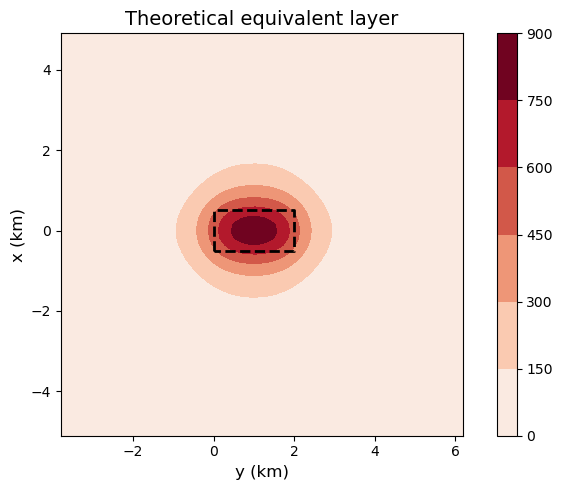

In [16]:
plt.figure(figsize=(7,5))

bounds = np.max(np.abs(p_theoretical))

plt.title('Theoretical equivalent layer', fontsize=14)
plt.axis('scaled')
plt.contourf(
    Y*0.001, X*0.001,
    utils.data_reshape(data=p_theoretical, ordering='xy', shape=coordinates_grid['shape']),  
    cmap='RdBu_r',
    vmin = -bounds, vmax = bounds
)
plt.colorbar()
plf.model_boundaries(model, m2km=True)
plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
plt.xlabel('y (km)', fontsize=12)
plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Magnetic field predicted by the theoretical equivalent layer

In [17]:
# magnetic field components
field_scales = [cts.T2MT, cts.T2NT, cts.T2NT, cts.T2NT]
field_names = ['potential', 'x', 'y', 'z']
field_units = ['$\mu$ T $\\times$ m', 'nT', 'nT', 'nT']

In [18]:
# compute the SEDM
R2 = inverse_distance.sedm_BTTB(
    data_grid = coordinates_grid, 
    delta_z = z_layer - coordinates_grid['z'],
    ordering = 'xy'
)

In [19]:
# compute the gradient components
Grad = inverse_distance.grad_BTTB(
    data_grid = coordinates_grid,
    delta_z = z_layer - coordinates_grid['z'],
    SEDM = R2,
    ordering = 'xy',
    components=['x', 'y', 'z']
)

In [20]:
# compute the tensor components
Tensor = inverse_distance.grad_tensor_BTTB(
    data_grid = coordinates_grid,
    delta_z = z_layer - coordinates_grid['z'],
    SEDM = R2,
    ordering = 'xy',
    components=['xx', 'xy', 'xz', 'yy', 'yz', 'zz']
)

In [21]:
# compute the eigenvalues matrices
L_Grad = dict()
for component in ['x', 'y', 'z']:
    L_Grad[component] = convolve.eigenvalues_BCCB(BTTB_metadata=Grad[component])

L_Tensor = dict()
for component in ['xx', 'xy', 'xz', 'yy', 'yz', 'zz']:
    L_Tensor[component] = convolve.eigenvalues_BCCB(BTTB_metadata=Tensor[component])

In [22]:
# list for storing the predicted magnetic field components
predicted_fields = []

In [23]:
# magnetic scalar potential
result = np.zeros_like(V)

for u_component, component in zip(u_hat, ['x', 'y', 'z']):
    result[:] -= u_component*convolve.product_BCCB_vector(
        eigenvalues = L_Grad[component],
        ordering = 'row',
        v = p_theoretical
    )

predicted_fields.append(field_scales[0] * result)

In [24]:
# magnetic induction field component x
result = np.zeros_like(bx)

for u_component, component in zip(u_hat, ['xx', 'xy', 'xz']):
    result[:] += u_component*convolve.product_BCCB_vector(
        eigenvalues = L_Tensor[component],
        ordering = 'row',
        v = p_theoretical
    )

predicted_fields.append(field_scales[1] * result)

# magnetic induction field component y
result = np.zeros_like(by)

for u_component, component in zip(u_hat, ['xy', 'yy', 'yz']):
    result[:] += u_component*convolve.product_BCCB_vector(
        eigenvalues = L_Tensor[component],
        ordering = 'row',
        v = p_theoretical
    )

predicted_fields.append(field_scales[2] * result)

# magnetic induction field component z
result = np.zeros_like(bz)

for u_component, component in zip(u_hat, ['xz', 'yz', 'zz']):
    result[:] += u_component*convolve.product_BCCB_vector(
        eigenvalues = L_Tensor[component],
        ordering = 'row',
        v = p_theoretical
    )

predicted_fields.append(field_scales[3] * result)

### Plot the results

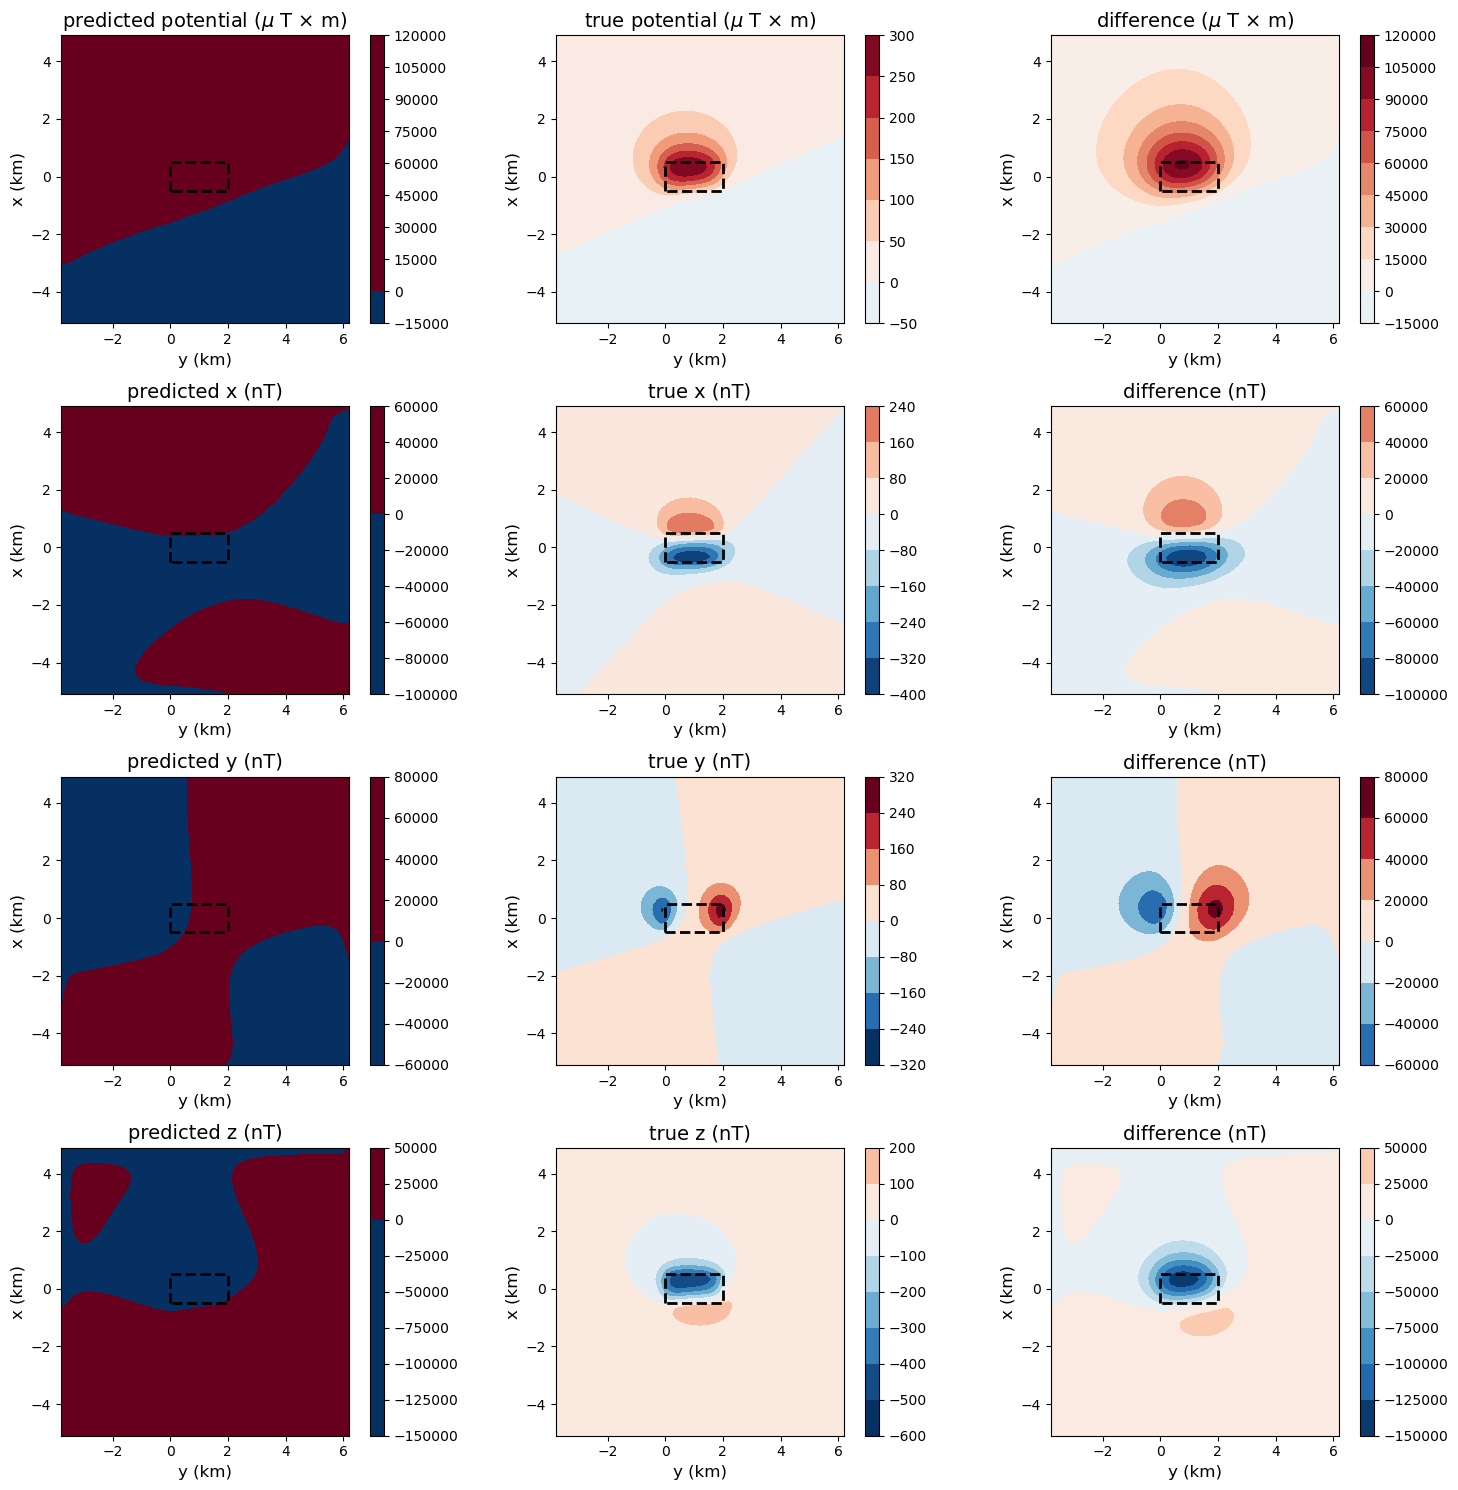

In [25]:
true_fields = [V, bx, by, bz]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('predicted {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,13)]

plt.figure(figsize=(15,15))

for w, window in enumerate(windows):

    plt.subplot(4,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        Y*0.001, X*0.001, 
        utils.data_reshape(fields[w], ordering='xy', shape=coordinates_grid['shape']), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*coordinates_grid['area'][0], 0.001*coordinates_grid['area'][1])
    plt.xlim(0.001*coordinates_grid['area'][2], 0.001*coordinates_grid['area'][3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()